In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [146]:
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
from torchsummary import summary

In [6]:
from torchvision.transforms import v2

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [8]:
from scipy.optimize import curve_fit
from collections import namedtuple

In [9]:
from pymono.aux_func import select_image_files, select_image_and_metadata, energy
from pymono.aux_func import select_image_and_lbl, get_energy, get_means_stds
from pymono.aux_func import mean_rms, weighted_mean_and_sigma, energy_h3d, corrected_energy

In [10]:
from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies, plot_corrected_energy
from pymono.plt_funcs import  plot_true_predicted, plotxyz, plotxyze, plot_h3d, plot_energies2, plot_loss
from pymono.plt_funcs import plot_images_ds, histoplot, plot_image_ds, plot_images_ds, plot_image

In [11]:
from pymono.cnn_func import  CNN

In [12]:
from pymono.cnn_func import  CNN_basic, CNN_3x3

In [13]:
from pymono.cnn_func import ResNet10

In [14]:
from pymono.cnn_fit import fit_dgaussian, bin_centers, bin_data, fit_coord, plotfxyz

In [15]:
from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [16]:
from pymono.cnn_eval import evaluate_cnn, cnn_evaluation, single_run, train_cnn
from pymono.cnn_eval import evaluate_cnnx, single_runx, train_cnnx

In [17]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [15]:
#device = "cpu"

In [18]:
data_dir = Path(os.environ['MONOLITH_DATA'])

In [149]:
cifar_dir = os.path.join(Path(os.environ['DATA'],'cifar'))

In [19]:
dir_root = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX")

In [166]:
def cnn4L(cols=1, chi=64, ck=[3,3,3,2], cp=[1,1,1,0], ps=[2,2,2,1], lr=[0.01, 0.01, 0.01, 0.01],num_clases=3):
    """
    Define a cNN with 4 layers. 
    input tensor: (N,C,H,W)

    h = H: Height of image.
    w = W: Width of image.
    ck: Size of the convolution kernel for each layer. 
    cp: Padding of the convolution for each layer.
    ps: stride o the MaxPool.
    lr: negative slope of the leaky relu
    
    """
    cnnt =namedtuple('cnnt', 'conv, relu bn, pool')
    #image = torch.randn(1,1,h,w)
   
    CNNT = []
    CNNT.append(cnnt(nn.Conv2d(cols, chi, ck[0], padding=cp[0]), nn.LeakyReLU(negative_slope=cp[0]),nn.BatchNorm2d(chi), nn.MaxPool2d(ps[0], ps[0])))
    CNNT.append(cnnt(nn.Conv2d(chi, chi*2, ck[1], padding=cp[1]), nn.LeakyReLU(negative_slope=cp[1]),nn.BatchNorm2d(chi*2), nn.MaxPool2d(ps[1], ps[1])))
    CNNT.append(cnnt(nn.Conv2d(chi*2, chi*4, ck[2], padding=cp[2]), nn.LeakyReLU(negative_slope=cp[2]), nn.BatchNorm2d(chi*4), nn.MaxPool2d(ps[2], ps[2])))
    CNNT.append(cnnt(nn.Conv2d(chi*4, chi*8, ck[3], padding=cp[3]), nn.LeakyReLU(negative_slope=cp[3]), nn.BatchNorm2d(chi*8), nn.MaxPool2d(ps[3], ps[3])))
    fc0 = nn.Linear(chi*8, num_clases)
    return CNNT, fc0

### model_4L_3222

- CNN consists of 4 layers of convolutions, the first  with kernel of 3x3 and the other three with a kernel of 2x2.
- Each kernel doubles the number of features and halves the number of spatial dimensions.
- Notice that model_4L_3332 reduces spatial dimensions of input kernel to 1x1 if the input kernel has spatial dimensions 16x16 and works also for a smaller kernel (e.g 8x8).

In [21]:
CNNT3222, fc0 = cnn4L(chi=64, ck=[3,2,2,2], cp=[1,1,1,1], ps=[2,2,2,2], lr=[0.01, 0.01, 0.01, 0.01],num_clases=3)

In [22]:
cnn_evaluation(torch.randn(1,1,16,16), CNNT3222)

shape of input image = torch.Size([1, 1, 16, 16])
shape of image after convolution 0 = torch.Size([1, 64, 16, 16])
shape of image after pool 0= torch.Size([1, 64, 8, 8])
shape of image after convolution 1 = torch.Size([1, 128, 9, 9])
shape of image after pool 1= torch.Size([1, 128, 4, 4])
shape of image after convolution 2 = torch.Size([1, 256, 5, 5])
shape of image after pool 2= torch.Size([1, 256, 2, 2])
shape of image after convolution 3 = torch.Size([1, 512, 3, 3])
shape of image after pool 3= torch.Size([1, 512, 1, 1])
shape of out image = torch.Size([1, 512, 1, 1])


In [23]:
cnn_evaluation(torch.randn(1,1,8,8), CNNT3222)

shape of input image = torch.Size([1, 1, 8, 8])
shape of image after convolution 0 = torch.Size([1, 64, 8, 8])
shape of image after pool 0= torch.Size([1, 64, 4, 4])
shape of image after convolution 1 = torch.Size([1, 128, 5, 5])
shape of image after pool 1= torch.Size([1, 128, 2, 2])
shape of image after convolution 2 = torch.Size([1, 256, 3, 3])
shape of image after pool 2= torch.Size([1, 256, 1, 1])
shape of image after convolution 3 = torch.Size([1, 512, 2, 2])
shape of image after pool 3= torch.Size([1, 512, 1, 1])
shape of out image = torch.Size([1, 512, 1, 1])


In [24]:
device

'cuda'

In [25]:
model_4L_3222 = CNN(CNNT3222, fc0, dropout=False).to(device)
print(model_4L_3222)

CNN(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=1)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=1)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slop

In [26]:
summary(model_4L_3222,(1,8,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
         LeakyReLU-2             [-1, 64, 8, 8]               0
       BatchNorm2d-3             [-1, 64, 8, 8]             128
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 128, 5, 5]          32,896
         LeakyReLU-6            [-1, 128, 5, 5]               0
       BatchNorm2d-7            [-1, 128, 5, 5]             256
         MaxPool2d-8            [-1, 128, 2, 2]               0
            Conv2d-9            [-1, 256, 3, 3]         131,328
        LeakyReLU-10            [-1, 256, 3, 3]               0
      BatchNorm2d-11            [-1, 256, 3, 3]             512
        MaxPool2d-12            [-1, 256, 1, 1]               0
           Conv2d-13            [-1, 512, 2, 2]         524,800
        LeakyReLU-14            [-1, 51

In [27]:
dir_root

'/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX'

# CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX_classification

- CsI crystal assumed cold (100 k hot/MeV)

#### Parameters
- 6x6 SiPMs, thus 16x16 matrix
- 50 k photons per point (CsI, with ~100 k photons/MeV)
- 0MHzDC 
- PTFE wrapping (all sides)
- LUT model
- Nexus simulation


### CNN classification
- Data has been labeled as 1c (1 cluster), 2c (2 clusters) and nc (more than 2 clusters).
- Network must be trained to classify then

## Setup

In [103]:
d1c = os.path.join(dir_root,"df1c")
d2c = os.path.join(dir_root,"df2c")
dnc = os.path.join(dir_root,"dfnc")

In [29]:
def get_file_names(path):
    fnpy = glob.glob(os.path.join(path, "*.npy"))
    fcsv = glob.glob(os.path.join(path, "*.csv"))
    images = [f1.split("/")[-1] for f1 in fnpy]
    imn = [int(im.split(".")[0].split("_")[1]) for im in images]
    imns = np.sort(imn)
    names_i = [f"{path}/images_{i}.npy" for i in imns]
    return names_i, fcsv

In [30]:
def get_image_file_data(img_names,img_file_index=0):
    iimg = img_file_index
    imgs  = np.load(img_names[iimg])  # loads the images corresponding to the file specii
    img_path = img_names[iimg]
    img_name = img_path.split("/")[-1]
    imn = int(img_name.split(".")[0].split("_")[1])
    return imgs, img_path, img_name, imn

In [31]:
def get_metadata(df, img_file_number):
    evt_id = img_file_number * 10000
    dfs = df[df["event_id"]>=evt_id]  # Images in first file have event numbers between 10,000 and 20,000
    dfs = dfs[dfs["event_id"]<evt_id + 10000]
    return dfs

In [32]:
def plot_images2(imgs, img_file_number, dfs, img_range, pixel_size = 6, grid_size=8):

    fig, axs = plt.subplots(2, 4,figsize=(14, 4))        
    ftx = axs.ravel()
    for i, ev in enumerate(range(*img_range)):  
        dfi = dfs.iloc[ev]
        x = dfi['x']
        y = dfi['y']
        evt = dfi['event_id']
        x_evt = (dfi['y'] + pixel_size*grid_size/2)/pixel_size - 0.5
        y_evt = (dfi['x'] + pixel_size*grid_size/2)/pixel_size - 0.5
       
        #print(f"ev = {ev}, event_id = {evt}, x = {x}, y = {y} xevt = {x_evt}, yevt = {y_evt}")
        
        ftx[i].imshow(imgs[ev,:,:])
        ftx[i].plot([x_evt],[y_evt],'o',color='red')



In [33]:

def get_energy2(imgs, img_file_number):
    """
    Compute the energy of the selected images by adding the contents (number of photons)
    in each pixel

    imgs is a file containing the imaged readout in the directory
    The images selected are those contained in the file especified by img_file_number
    
    """
    imgx = imgs[img_file_number:,:,:]
    energies = [imgs[i].sum() for i in range(0,imgs.shape[0])]
    return np.array(energies)
   

In [34]:
def fit_gaussian(xdata, ydata, pars=[10000., 0.5, 2.0],
                 lower_bounds = [0, -1.0, 0.0],
                 upper_bounds = [100000, 1.0, 15.0]
                 ):

    def gaussian(x, a1, mu1, sigma1):
        return a1*(np.exp(-(x-mu1)**2/(2*sigma1**2)))
    
    pars, cov = curve_fit(gaussian, xdata, ydata, p0=pars, 
                          bounds=(lower_bounds, upper_bounds))
    err       = np.sqrt(np.diag(cov))
    fit_y     = gaussian(xdata, *pars) 
    return pars, err, fit_y 

In [35]:
def fit_energy(energy, bins=100, thr=3, xrange=(12e+3, 14e+3), mode='thr'):
    xdata, ydata = bin_data(energy, bins)

    if mode == 'thr':
        yy = ydata[ydata >thr]
        ym = np.isin(ydata, yy)
        xx = xdata[ym]
    else:
        xx = gdf3[(xdata >=xrange[0]) & (xdata<xrange[1])]
        xm = np.isin(xdata, xx)
        yy = ydata[xm]
    
    pars, err, yfit = fit_gaussian(xx, yy, pars=[10000., 15000, 500],
                                   lower_bounds = [0, 5000, 10],
                                   upper_bounds = [30000, 25000, 5000])
    fitg = namedtuple('fitg','xdata, ydata, xft, yft, yfit, norm, mu, sigma') 
    return fitg(xdata, ydata, xx, yy, yfit, pars[0],pars[1], pars[2])


In [36]:
def print_energy_fit(fe):
    print(f"fit parameters: norm = {fe.norm}, mu ={fe.mu}, sigma ={fe.sigma}")
    print(f"sigma/mu = {fe.sigma/fe.mu}: FWHM (%) = {2.23 * 100 * fe.sigma/fe.mu}")

In [37]:
def plot_energy_fit(fenergy, figsize=(4, 4)):
        
    fig, ax0 = plt.subplots(1, 1, figsize=figsize)
    ax0.errorbar(fenergy.xft, fenergy.yft,yerr=np.sqrt(fenergy.yft), fmt='o', markersize=2)
    ax0.plot(fenergy.xft, fenergy.yfit, 'red', linewidth=1.0,
                label=f"$\mu$ = {fenergy.mu:.2f}\n $\sigma$ = {fenergy.sigma:.2f}")
    ax0.legend()
    ax0.set_xlabel("Energy (photons)",fontsize=14)
    ax0.set_ylabel("Counts/bin",fontsize=14)
    
    fig.tight_layout()
    plt.show()

In [87]:
def get_means_stds2(dir):
    means =[]
    stds =[]
    img_names, _ = get_file_names(dir)
    print(f"files in dir: {len(img_names)}")
    for i,img in enumerate(img_names):
        images = np.load(img)
        if i == 1:
            print(f"shape -> {images.shape}")
            print(f"mean img0 ={np.mean(images[0,:,:])}")
            print(f"std  img0 ={np.std(images[0,:,:])}")
        means.append(np.mean(images, axis=(1,2)))
        stds.append(np.std(images, axis=(1,2)))
    return means, stds

In [93]:
def histoplot(var, varlbl, vart=" ", num_bins = 50, figsize=(6, 4)):
    _, std, _    = mean_rms(var)
    
    fig, ax0 = plt.subplots(1, 1, figsize=figsize)
    _, _, _ = ax0.hist(var, num_bins, label=f"$\sigma$ = {std:.2f}")
    ax0.set_xlabel(varlbl)
    ax0.set_ylabel('Events/bin')
    ax0.set_title(vart)
    ax0.legend()

    fig.tight_layout()
    plt.show()

In [38]:
img_names, csv_name = get_file_names(d1c)

In [39]:
csv_name

['/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX/df1c/mf1c.csv']

In [40]:
img_names[0]

'/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX/df1c/images_1.npy'

In [41]:
df1c = pd.read_csv(csv_name[0]).sort_values(by="event_id")
df1c.head(10)

,event_id,e,x,y,z,t
63683,10004,0.510118,18.645067,12.477487,29.249544,0.116340
63684,10006,0.509274,13.566376,1.647984,21.156849,0.090734
63685,10014,0.509922,-5.014233,5.060986,12.715019,0.062352
63686,10018,0.508170,-22.957691,-9.322307,45.483715,0.171746
63687,10024,0.508948,-3.514938,-0.639491,15.746504,0.074194
63688,10026,0.508879,18.973616,-6.031100,16.421364,0.074508
63689,10027,0.508849,11.437413,-22.155209,40.912632,0.157729
63690,10028,0.509717,9.708068,3.101630,13.316263,0.064982
63691,10029,0.509517,0.335767,-11.193620,21.898740,0.093051
63692,10030,0.509092,16.716444,15.401320,25.922293,0.107143


In [150]:
def cifar_data_loader(data_dir,
                      batch_size,
                      random_seed=42,
                      valid_size=0.1,
                      shuffle=True,
                      norm = True, 
                      test=False):
  
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    stransform = transforms.Compose([
            transforms.ToTensor(),
    ])
    transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
    ])

    if test:
        if norm:
            dataset = datasets.CIFAR10(
              root=data_dir, train=False,
              download=True, transform=transform,
            )
        else:
            dataset = datasets.CIFAR10(
              root=data_dir, train=False,
              download=True, transform=stransform,
            )

        data_loader = DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle
        )

        return data_loader

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              sampler=train_sampler)
 
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=batch_size, 
                              sampler=valid_sampler)

    return (train_loader, valid_loader)



In [42]:
class XDataset(Dataset):
    """
    Loads images to pytorch for classification as 1c (1), 2c(2), >2c(3) 
    self.dataset ->[d1, d2...] where di ->[img (normalized), scalar (1,2,3)] 
    
    """

    def __init__(self, dir_root: str, frst_file: int, lst_file: int, 
                 norm=False, mean=None, std=None, random_seed=42):

        def append_images(img_names, imgt_type):
            print(f" Image type = {imgt_type}")
            
            for img_file_index in range(frst_file, lst_file):
                images, imgf_path, _, _ = get_image_file_data(img_names,img_file_index)
                #print(f"image file path = {imgf_path}")
                #print(f"number of images in file = {len(images)}")
                
                for img in images:
                    #print(f"append image =>{img}")
                    #print(f"append img_tupe =>{imgt_type}")
                    self.dataset.append((img, imgt_type))
                    
        self.norm=norm 
        self.dataset = []
        self.transf = None 

        d1c = os.path.join(dir_root,"df1c")  # directory with images 1c
        d2c = os.path.join(dir_root,"df2c")  # directory with images 1c
        dnc = os.path.join(dir_root,"dfnc")  # directory with images nc

        print(f"Running XDataset with norm = {self.norm}")
        print(f"directory for 1c = {d1c}, 2c = {d2c}, >2c = {dnc}")

        if norm == True:
            self.transf = v2.Normalize(mean=[mean], std=[std])

        img_names, _ = get_file_names(d1c)  # get images of 1c
        append_images(img_names,0)
        
        img_names, _ = get_file_names(d2c)  # get images of 2c
        append_images(img_names,1)

        img_names, _ = get_file_names(dnc)  # get images of 2c
        append_images(img_names,2)

        self.si = list(range(len(self.dataset)))
        print(f"Before shufle: length si: {len(self.si)}, si->{self.si[0:10]}")
        np.random.seed(random_seed)
        np.random.shuffle(self.si)
        print(f"After shufle: length si: {len(self.si)}, si->{self.si[0:10]}")

        
        
    def __len__(self):
        return len(self.dataset)
    

    def __getitem__(self, idx):
        image, imgtype = self.dataset[self.si[idx]]
        image = torch.tensor(image, dtype=torch.float).unsqueeze(0) # Add channel dimension
        imgtype = torch.tensor(imgtype)

        if self.norm == True:
            image = self.transf(image)
        return image, imgtype

In [43]:
imgs, imgf_path, imgf_name, imfn = get_image_file_data(img_names,img_file_index=0)
print(f"image file path = {imgf_path}")
print(f"image file name = {imgf_name}")
print(f"image file number = {imfn}")
print(f"number of images in file = {len(imgs)}")

image file path = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX/df1c/images_1.npy
image file name = images_1.npy
image file number = 1
number of images in file = 2481


In [44]:
df1cs = get_metadata(df1c, imfn)  # This are the events corresponding to the images
print(f"number of labels in file = {len(df1cs)}")

number of labels in file = 2481


In [45]:
df1cs.head(10)

,event_id,e,x,y,z,t
63683,10004,0.510118,18.645067,12.477487,29.249544,0.116340
63684,10006,0.509274,13.566376,1.647984,21.156849,0.090734
63685,10014,0.509922,-5.014233,5.060986,12.715019,0.062352
63686,10018,0.508170,-22.957691,-9.322307,45.483715,0.171746
63687,10024,0.508948,-3.514938,-0.639491,15.746504,0.074194
63688,10026,0.508879,18.973616,-6.031100,16.421364,0.074508
63689,10027,0.508849,11.437413,-22.155209,40.912632,0.157729
63690,10028,0.509717,9.708068,3.101630,13.316263,0.064982
63691,10029,0.509517,0.335767,-11.193620,21.898740,0.093051
63692,10030,0.509092,16.716444,15.401320,25.922293,0.107143


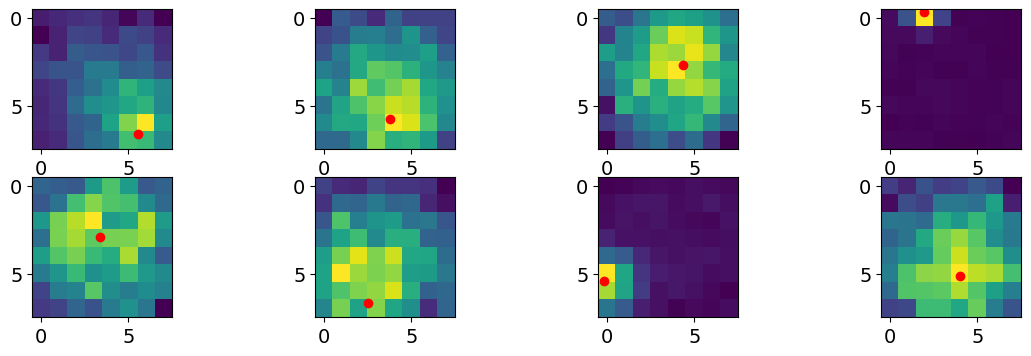

In [46]:
plot_images2(imgs, imfn, df1cs, (0,8), pixel_size = 6, grid_size=8)

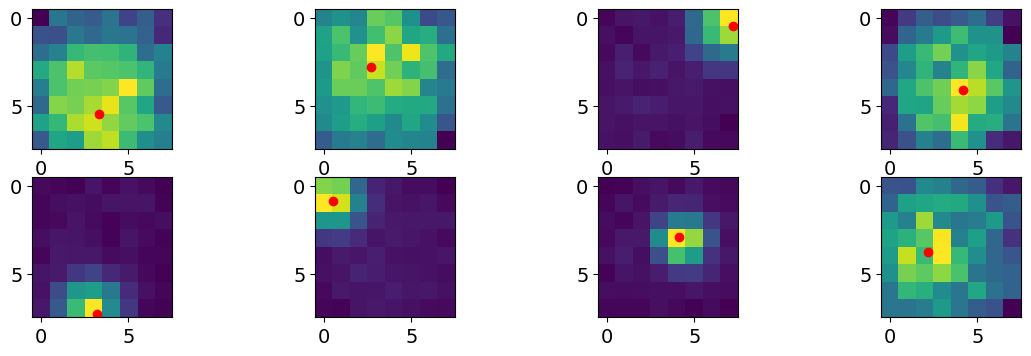

In [47]:
plot_images2(imgs, imfn, df1cs, (100,108), pixel_size = 6, grid_size=8)

In [48]:
energy = get_energy2(imgs, 9)

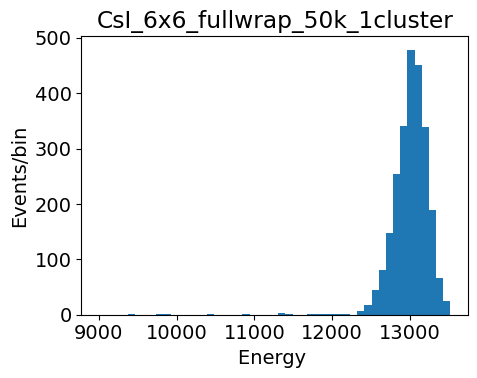

In [49]:
plot_energies2({"CsI_6x6_fullwrap_50k_1cluster":energy}, xmin=9000, xmax=max(energy),num_bins = 50)

In [50]:
mean6x6, std6x6, fwhm6x6 = mean_rms(energy)

print(f"mean = {mean6x6:.2f} sigma = {100*std6x6:.2f} % FWHM = {100*fwhm6x6:.2f} %")

mean = 12948.19 sigma = 5.68 % FWHM = 13.06 %


In [51]:
fenergy = fit_energy(energy, bins=300,thr=3, mode='thr')

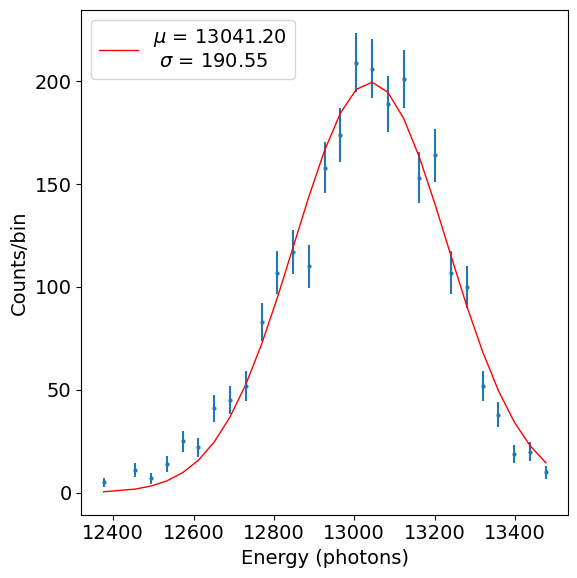

In [52]:
plot_energy_fit(fenergy, figsize=(6, 6))

In [53]:
print_energy_fit(fenergy)

fit parameters: norm = 199.55453916875763, mu =13041.19549793181, sigma =190.5453530914839
sigma/mu = 0.014611034174106375: FWHM (%) = 3.2582606208257214


## CIFAR

In [151]:
test_loader_nn = cifar_data_loader(data_dir=cifar_dir, norm=False, test=True,
                                   batch_size=64)

100%|███████████████████████| 170498071/170498071 [00:07<00:00, 21578790.88it/s]


Extracting /home/investigator/Data/cifar/cifar-10-python.tar.gz to /home/investigator/Data/cifar


Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])
torch.Size([3, 32, 32])


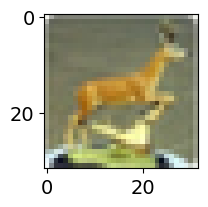

Label: 4


In [167]:
# Display image and label.
plt.rcParams["figure.figsize"] = 2, 2
train_features, train_labels = next(iter(test_loader_nn))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
print(img.shape)
#plt.imshow(img.T)
#print(img)
plt.imshow(transforms.ToPILImage()(img))
#plt.imshow(img.permute(*torch.arange(img.ndim - 1, -1, -1)))
plt.show()
print(f"Label: {label}")
plt.rcParams["figure.figsize"] = 10, 8

In [153]:
train_loader_cf, valid_loader_cf = cifar_data_loader(data_dir=cifar_dir,
                                         batch_size=64)

test_loader_cf = cifar_data_loader(data_dir=cifar_dir,
                              batch_size=64,
                              test=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [155]:
total_step = len(train_loader_cf)
print(f"length of train series: {total_step}")
print(f"length of validation series: {len(valid_loader_cf)}")
train_features, train_labels = next(iter(test_loader_cf))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

length of train series: 704
length of validation series: 79
Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


In [168]:
CNNT322210f, fc0 = cnn4L(cols=3,chi=64, ck=[3,2,2,2], cp=[1,1,1,1], ps=[2,2,2,2], lr=[0.01, 0.01, 0.01, 0.01],num_clases=10)

In [180]:
cnn_evaluation(torch.randn(1,3,32,32), CNNT322210f)

shape of input image = torch.Size([1, 3, 32, 32])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [175]:
model_4L_3222_10f = CNN(CNNT322210f, fc0, dropout=True).to(device)
print(model_4L_3222_10f)


CNN(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=1)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=1)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=1)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slop

In [177]:
summary(model_4L_3222_10f,(3,32,32))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x2048 and 512x10)

In [176]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4L_3222_10f.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  


In [173]:
def single_run_x(train_loader, device, model, criterion, optimizer):
    print(f"** Run for 1 event**")

    for epoch in range(1):
        print(f"epoch = {epoch}")
    
        for i, (images, labels) in enumerate(train_loader):  
            if i>1: break
            print(f"i = {i}")
            print(f"labels = {labels}")
            images = images.to(device)
            labels = labels.to(device)
            
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)

            print(f"outputs = {outputs.data.shape}")
            _, predicted = torch.max(outputs.data, 1)
            print(f"predicted label = {predicted}")
            correct = (predicted == labels).sum().item()
            print(f"correct = {correct}")
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            
            loss.backward()
            optimizer.step()
    
            print(f"Train Step {i + 1}/{len(train_loader)}, Loss: {loss.data.item()}")
                


In [174]:
single_run_x(train_loader_cf, device, model_4L_3222_10f, criterion, optimizer)

** Run for 1 event**
epoch = 0
i = 0
labels = tensor([8, 6, 8, 1, 9, 7, 6, 2, 9, 1, 1, 0, 7, 6, 5, 8, 2, 3, 8, 8, 2, 7, 2, 9,
        8, 8, 4, 9, 5, 1, 3, 6, 4, 5, 2, 8, 9, 9, 3, 5, 9, 0, 1, 6, 9, 0, 4, 1,
        9, 6, 9, 1, 8, 6, 1, 0, 1, 6, 2, 4, 3, 4, 3, 8])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x100352 and 512x10)

## Short run
- Use a fraction (1/3) of data set.
- No normalization

In [72]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 100  # Batch size
train_fraction=0.7 
val_fraction=0.2


In [73]:
# xyze = True for new data sets where the csv includes (x,y,z,nphot) but the network 
# compares with xyz. For old data sets (x,y,z) or new data sets comparing with a net of
# x,y,z,e output, use xyze = False (or remove, it is the default). 

dataset = XDataset(dir_root, first_file, last_file,norm=False)  


Running XDataset with norm = False
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX/df2c, >2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX/dfnc
 Image type = 0
 Image type = 1
 Image type = 2
Before shufle: length si: 512770, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 512770, si->[115481, 208736, 461043, 162373, 418200, 479114, 338695, 506523, 461126, 152977]


In [74]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 512770 events
 train size = 358939
 val size = 102554
 test size = 51277
 train indices = range(0, 358939)
 val indices = range(358939, 461493)
 test indices = range(461493, 512770)
358939 training events (70.0%)
102554 validation events (20.0%)
51277 test events (10.0%)


In [75]:
lbls = [dataset[i][1].item() for i in range(0, len(dataset))]

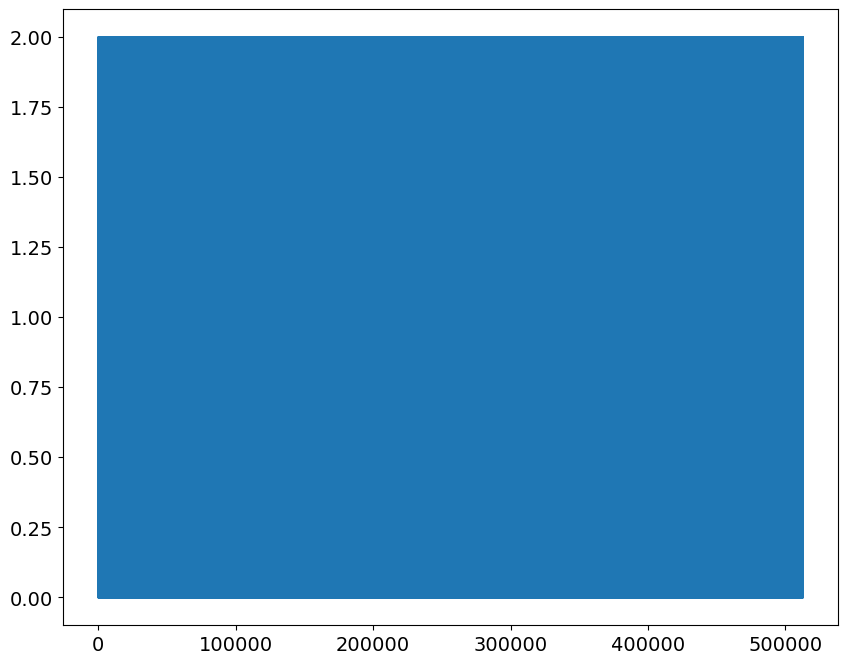

In [76]:
plt.plot(lbls)

In [77]:
def plot_images_and_labels(train_loader, start=0, figsize=(10, 8)):
    IMG = []
    LBL = []

    for i in range(0,start):
        train_features, train_labels = next(iter(train_loader))
    
    for i in range(0,9):
        train_features, train_labels = next(iter(train_loader))
    
        IMG.append(train_features[0].squeeze())
        LBL.append(train_labels[0])
        
    fig, axs = plt.subplots(3, 3,figsize=figsize)        
    ftx = axs.ravel()
    for  i in range(0,9):        
        img = IMG[i]
        lbl = LBL[i]
        ftx[i].imshow(transforms.ToPILImage()(img))
        ftx[i].text(2, 2, f'{lbl}', color='red', ha='center') 
        #ftx[i].title("label")
    plt.show()
    #print(f"Label: {label}")

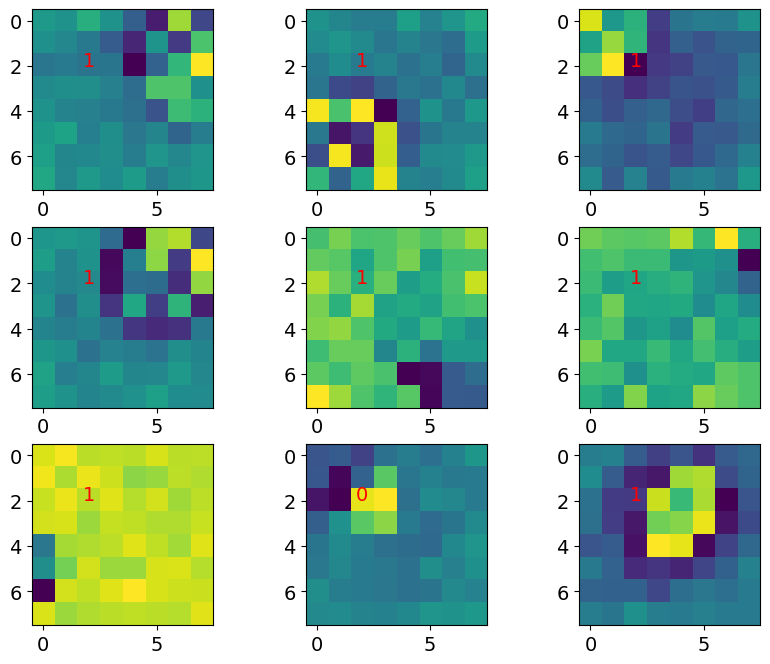

In [78]:
plot_images_and_labels(train_loader, start=500, figsize=(10, 8))

In [79]:
model_4L_3222 = CNN(CNNT3222, fc0, dropout=True).to(device)
#optimizer = optim.Adam(model_4L_3222.parameters(), lr=0.001)
#criterion = nn.MSELoss()

In [80]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4L_3222.parameters(), lr=0.01, weight_decay = 0.001, momentum = 0.9)  


In [64]:
def single_run_pred(train_loader, device, model, optimizer, criterion):
    print(f"** Run for 1 event**")

    for epoch in range(1):
        print(f"epoch = {epoch}")
    
        for i, (images, labels) in enumerate(train_loader):  
            if i>1: break
            print(f"i = {i}")
            print(f"labels = {labels}")
            images = images.to(device)
            labels = labels.to(device)
            
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)

            print(f"outputs = {outputs.data.shape}")
            _, predicted = torch.max(outputs.data, 1)
            print(f"predicted label = {predicted}")
            correct = (predicted == labels).sum().item()
            print(f"correct = {correct}")
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            
            loss.backward()
            optimizer.step()
    
            print(f"Train Step {i + 1}/{len(train_loader)}, Loss: {loss.data.item()}")

In [65]:
single_run_pred(train_loader, device, model_4L_3222, optimizer,criterion)

** Run for 1 event**
epoch = 0
i = 0
labels = tensor([1, 2, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 2, 0, 2,
        2, 1, 2, 0, 1, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 1, 0, 1, 1, 1, 2, 2, 1, 1, 0,
        0, 2, 0, 1])
outputs = torch.Size([100, 3])
predicted label = tensor([2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2,
        2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1,
        1, 1, 2, 2], device='cuda:0')
correct = 23
Train Step 1/357, Loss: 1.3130377531051636
i = 1
labels = tensor([2, 0, 0, 0, 0, 2, 1, 1, 1, 0, 1, 0, 1, 0, 2, 2, 0, 0, 2, 0, 1, 0, 0, 1,
        0, 1, 2, 0, 0, 2, 0, 2, 1, 0, 2, 2, 2, 1, 2, 2,

In [66]:
def train_cnn_pred(train_loader, val_loader, model, optimizer, device, criterion, 
              iprnt=100, epochs=10):
    """
    train the CNN
    """
    train_losses, val_losses, acc = [], [], []
    print(f"Running for epochs ->{epochs}")
    
    for epoch in range(epochs):
        train_losses_epoch, val_losses_epoch = [], []

        print(f"\nEPOCH {epoch}")

        print(f"Training step: size of sample {len(train_loader)}")
        for i, (images, labels) in enumerate(train_loader):

            images = images.to(device)
            labels = labels.to(device)

            model.train()  #Sets the module in training mode.
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            outputs = model(images) # image --> model --> (x,y,z)
            loss = criterion(outputs, labels) # compare labels with predictions
            loss.backward()  # backward pass
            optimizer.step()
            
            train_losses_epoch.append(loss.data.item())
            if((i+1) % (iprnt) == 0):
                print(f"Train Step {i + 1}/{len(train_loader)}, Loss: {loss.data.item()}")
                
        
        # Validation step
        with torch.no_grad():  #gradients do not change
            model.eval()       # Sets the module in evaluation mode.
            correct = 0
            total = 0
            print(f"Validation step: size of sample {len(val_loader)}")
            for i, (images, labels) in enumerate(val_loader):
                #print(f"labels =>{labels}")
                
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_losses_epoch.append(loss.data.item())
                
                if((i+1) % (iprnt) == 0):
                    print(f"Validation Step {i + 1}/{len(val_loader)}, Loss: {loss.data.item()}")

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_losses.append(np.mean(train_losses_epoch))
        val_losses.append(np.mean(val_losses_epoch))
        acc.append(100 * correct / total)
        
        print(f"--- EPOCH {epoch} AVG TRAIN LOSS: {np.mean(train_losses_epoch)}")
        print(f"--- EPOCH {epoch} AVG VAL LOSS: {np.mean(val_losses_epoch)}")
        print(f'Accuracy on the {len(val_loader)} validation images: {100 * correct / total} %') 
    
    return train_losses, val_losses, acc


In [81]:
train_losses, val_losses, acc = train_cnn_pred(train_loader, val_loader, model_4L_3222, 
                                               optimizer, device, criterion, 
                                               iprnt=1000, epochs=20)


Running for epochs ->20

EPOCH 0
Training step: size of sample 3590
Train Step 1000/3590, Loss: 0.9341607689857483
Train Step 2000/3590, Loss: 0.8730204701423645
Train Step 3000/3590, Loss: 0.9331400990486145
Validation step: size of sample 1026
Validation Step 1000/1026, Loss: 0.9574592113494873
--- EPOCH 0 AVG TRAIN LOSS: 0.9394944523038307
--- EPOCH 0 AVG VAL LOSS: 0.9387918129766661
Accuracy on the 1026 validation images: 52.2807496538409 %

EPOCH 1
Training step: size of sample 3590
Train Step 1000/3590, Loss: 0.9602643847465515
Train Step 2000/3590, Loss: 0.9477933645248413
Train Step 3000/3590, Loss: 1.0039818286895752
Validation step: size of sample 1026
Validation Step 1000/1026, Loss: 0.9084328413009644
--- EPOCH 1 AVG TRAIN LOSS: 0.9333561354028813
--- EPOCH 1 AVG VAL LOSS: 0.9354216235655325
Accuracy on the 1026 validation images: 51.61378395771983 %

EPOCH 2
Training step: size of sample 3590
Train Step 1000/3590, Loss: 0.8289377689361572
Train Step 2000/3590, Loss: 0.8904

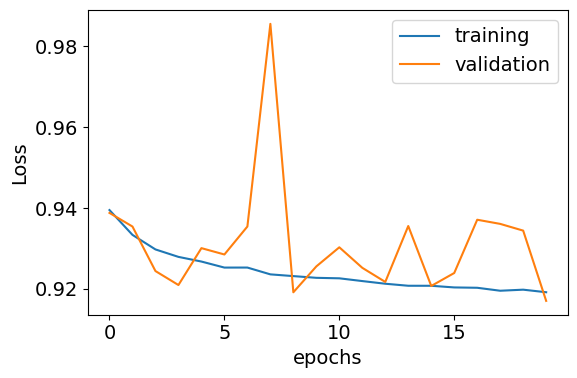

In [82]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))

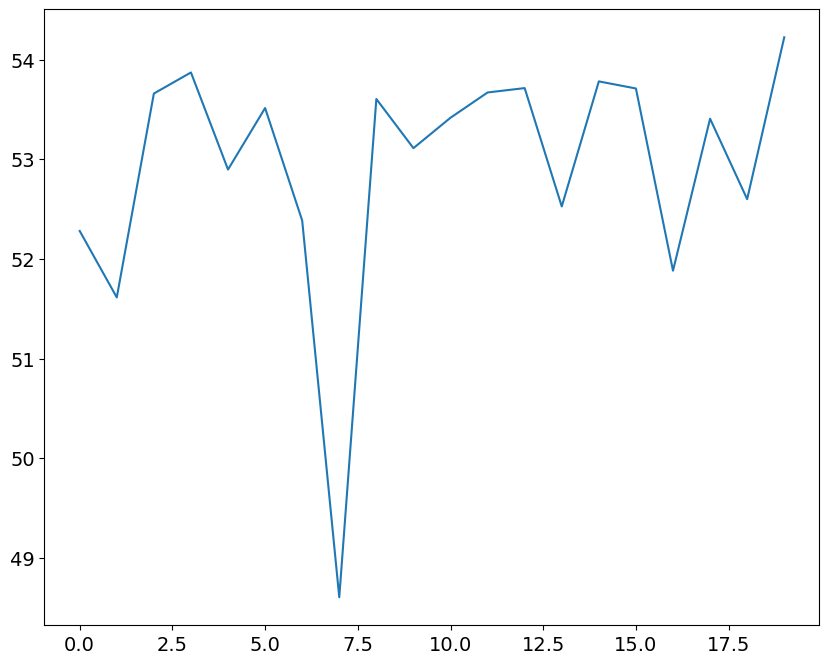

In [83]:
plt.plot(acc)

## Normalization

In [88]:
means, stds = get_means_stds2(dir=d1c)

files in dir: 100
shape -> (2455, 8, 8)
mean img0 =200.9375
std  img0 =49.51542663574219


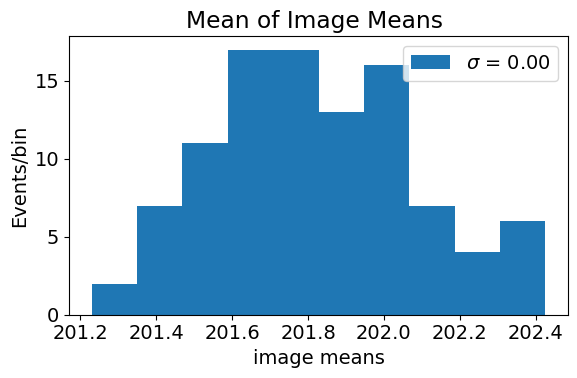

In [97]:
meansx =[np.mean(x) for x in means]
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [98]:
imean = np.mean(meansx)

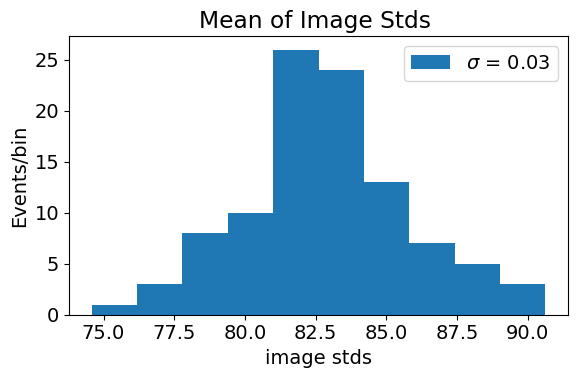

In [99]:
stdsx =[np.std(x) for x in stds]
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [100]:
isigma = np.mean(stdsx)

In [101]:
print(f"Normalization: mean = {imean}, std = {isigma}")

Normalization: mean = 201.8215789794922, std = 82.87454223632812


In [104]:
means2, stds2 = get_means_stds2(dir=d2c)

files in dir: 100
shape -> (1891, 8, 8)
mean img0 =205.46875
std  img0 =33.66422653198242


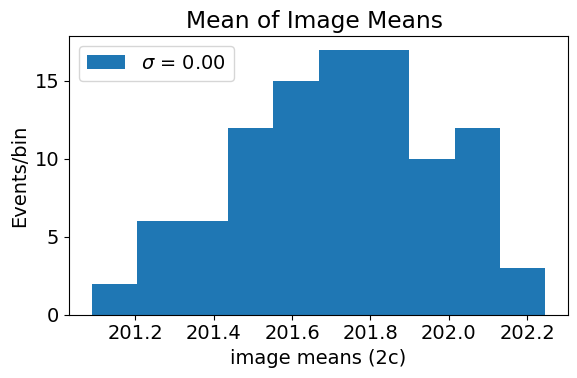

In [106]:
meansx2 =[np.mean(x) for x in means2]
histoplot(meansx2, "image means (2c)", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [107]:
imean2 = np.mean(meansx2)

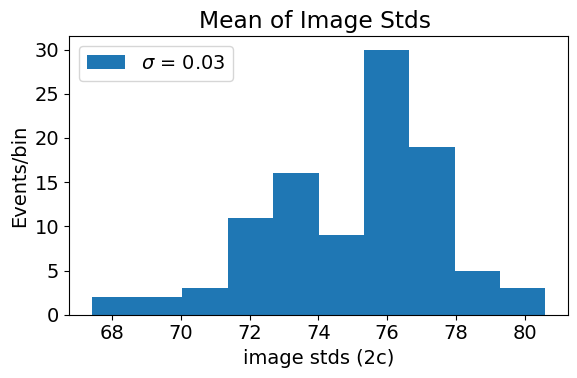

In [113]:
stdsx2 =[np.std(x) for x in stds2]
histoplot(stdsx2, "image stds (2c)", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [114]:
isigma2 = np.mean(stdsx2)

In [115]:
print(f"Normalization 2c: mean = {imean2}, std = {isigma2}")

Normalization 2c: mean = 201.72137451171875, std = 75.02996063232422


In [105]:
means3, stds3 = get_means_stds2(dir=dnc)

files in dir: 100
shape -> (745, 8, 8)
mean img0 =199.28125
std  img0 =51.78937911987305


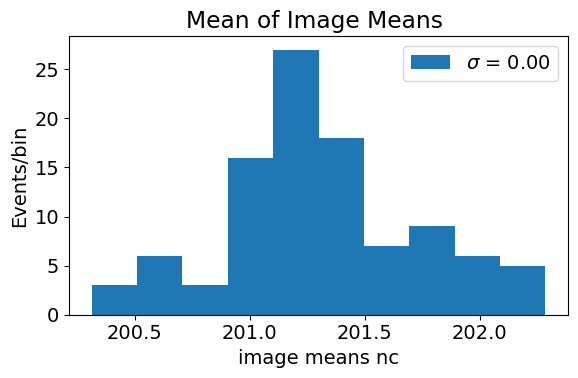

In [111]:
meansx3 =[np.mean(x) for x in means3]
histoplot(meansx3, "image means nc", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [112]:
imean3 = np.mean(meansx3)

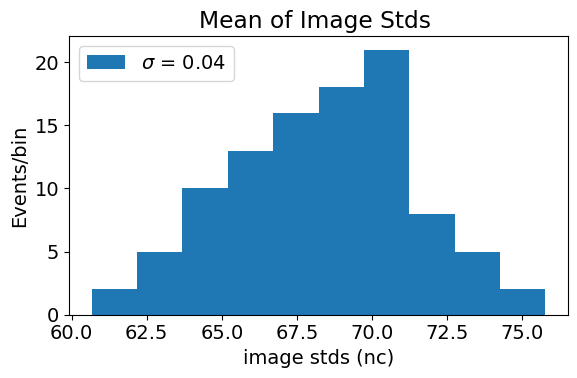

In [116]:
stdsx3 =[np.std(x) for x in stds3]
histoplot(stdsx3, "image stds (nc)", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [117]:
isigma3 = np.mean(stdsx3)

In [118]:
print(f"Normalization nc: mean = {imean3}, std = {isigma3}")

Normalization nc: mean = 201.3074951171875, std = 68.3232192993164


### Run with full stats and normalization 

In [53]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 100  # Batch size
train_fraction=0.7 
val_fraction=0.2

In [119]:
dataset = XDataset(dir_root, first_file, last_file,norm=True, mean=imean, std=isigma)  # No comparison with energy only xyz



Running XDataset with norm = True
directory for 1c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX/df1c, 2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX/df2c, >2c = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_NX/dfnc
 Image type = 0
 Image type = 1
 Image type = 2
Before shufle: length si: 512770, si->[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
After shufle: length si: 512770, si->[115481, 208736, 461043, 162373, 418200, 479114, 338695, 506523, 461126, 152977]


In [120]:
 data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
    

Loaded 512770 events
 train size = 358939
 val size = 102554
 test size = 51277
 train indices = range(0, 358939)
 val indices = range(358939, 461493)
 test indices = range(461493, 512770)
358939 training events (70.0%)
102554 validation events (20.0%)
51277 test events (10.0%)


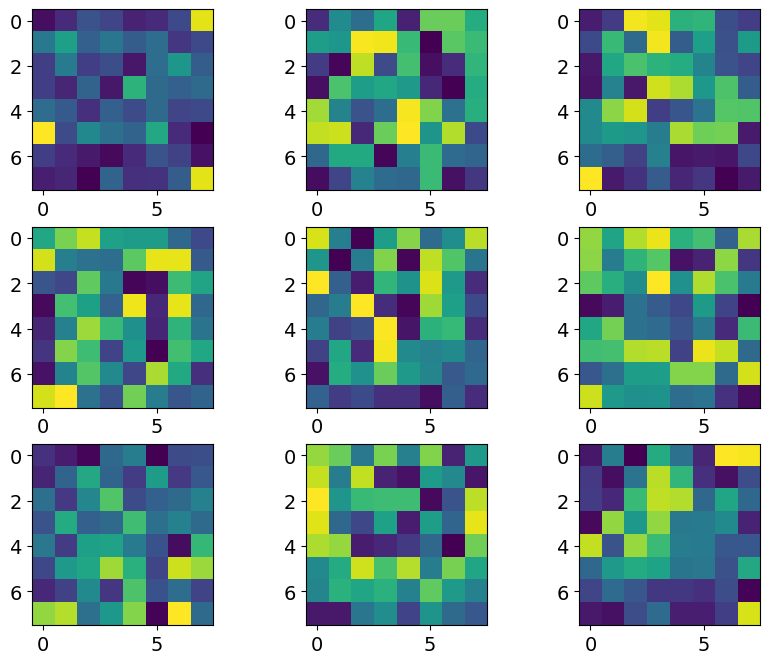

In [121]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [123]:
train_losses, val_losses, acc = train_cnn_pred(train_loader, val_loader, model_4L_3222, 
                                               optimizer, device, criterion, 
                                               iprnt=1000, epochs=20)


Running for epochs ->20

EPOCH 0
Training step: size of sample 3590
Train Step 1000/3590, Loss: 0.9191511273384094
Train Step 2000/3590, Loss: 0.8991628885269165
Train Step 3000/3590, Loss: 0.9479602575302124
Validation step: size of sample 1026
Validation Step 1000/1026, Loss: 0.8737459778785706
--- EPOCH 0 AVG TRAIN LOSS: 0.9202180816602574
--- EPOCH 0 AVG VAL LOSS: 0.9208478940393028
Accuracy on the 1026 validation images: 53.79312362267683 %

EPOCH 1
Training step: size of sample 3590
Train Step 1000/3590, Loss: 0.8945581912994385
Train Step 2000/3590, Loss: 0.932607889175415
Train Step 3000/3590, Loss: 0.9705297946929932
Validation step: size of sample 1026
Validation Step 1000/1026, Loss: 0.8748498558998108
--- EPOCH 1 AVG TRAIN LOSS: 0.9200846543385126
--- EPOCH 1 AVG VAL LOSS: 0.9419861783293488
Accuracy on the 1026 validation images: 52.24272090800944 %

EPOCH 2
Training step: size of sample 3590
Train Step 1000/3590, Loss: 0.9302240610122681
Train Step 2000/3590, Loss: 0.9219

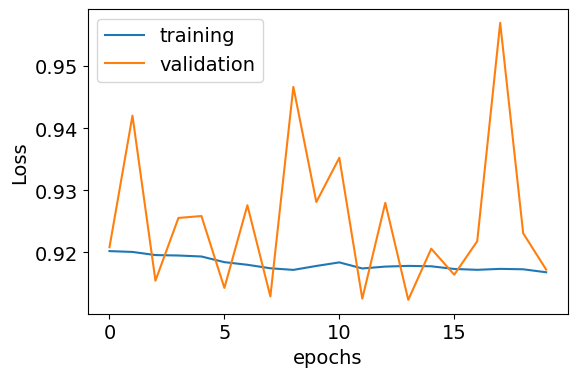

In [124]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))

### Deeper network

In [132]:
class ResBlock(nn.Module):
    """
    Implements a residual block consisting in [Conv2d->BatchNorm2d->ReLU] + 
    [Conv2d->BatchNorm2d]. This residual is added to the input (then a second activation ReLU applied)
    
    If downsample = None (e.g, default first pass), then we obtain f(x) + x where 
    f(x) -> [Conv2d->BatchNorm2d->ReLU ->Conv2d->BatchNorm2d]. Otherwise the block is skipped. 
    
    """
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                                  stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                                  stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x # This is the residual (in the case of no downsample)
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:  # this is the residual in the case of downsample
            residual = self.downsample(x)
            
        out += residual # This is it! f(x) + x 
        out = self.relu(out)

        return out

In [136]:
class ResNet10(nn.Module):
    """
    Implements the Residual Network with 34 layers:
    The architecture is like this:
    1. Image passes through a convolution (kernel 3x3) 
    with stride = 1 and padding = 1 which increases the features from 3 to 64 and 
    preserves spatian dimensions, then batch normalization and activation. 
    # (W,H,1) => (W,H,64)
    
    2. The layer architecture is as follows (with a skip connection between each pair of layers) 
        6 layers of convolution 3x3 with 64 features
        8 layers of convolution 3x3 with 128 features (max pool 56 -> 28)
        12 layers of convolution 3x3 with 256 features (max pool 28 -> 24)
        6 layers of convolution 3x3 with 512 features (max pool 14 -> 7)
    3. Then avgpool and fc.
    
    """
    def __init__(self, block, num_classes = 3, dropout=False, dropout_fraction=0.2, debug=False):
        super(ResNet10, self).__init__()
        self.debug = debug
        self.inplanes = 64

        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(2, 2)
        self.layer0 = self._make_layer(block, 64, 1, stride = 1, nlyr = 1)
        self.layer1 = self._make_layer(block, 128, 1, stride = 2, nlyr = 2)
        self.layer2 = self._make_layer(block, 256, 1, stride = 2, nlyr = 3)
        self.layer3 = self._make_layer(block, 512, 1, stride = 2, nlyr = 4)
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = dropout
        self.drop1 = nn.Dropout(p=dropout_fraction)

           
    def _make_layer(self, block, planes, blocks, stride, nlyr):
        downsample = None
        
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        if self.debug:
            print(f" ## make_layer {nlyr}: planes = {planes},  blocks = {blocks}, stride = {stride}")
            print(f" ## make_layer: in_planes={self.inplanes}")
            print(f" ## make_layer: downsample = {downsample}")
            #print(f"layer block = 0: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = {stride}, downsample = {downsample}")
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            if self.debug:
                print(f" layer block = {i}: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = 1, downsample = None")

        return nn.Sequential(*layers)
    
    def forward(self, x):
        if(self.debug): print(f" ResNet10: input data shape =>{x.shape}")
            
        x = self.conv1(x)
        if(self.debug): print(f" ResNet10: after conv1 =>{x.shape}")
            
        #x = self.maxpool(x)
        #if(self.debug): print(f" ResNet: after maxpool =>{x.shape}")
            
        x = self.layer0(x)
        if(self.debug): print(f" ResNet10: after layer0 =>{x.shape}")
        
        x = self.layer1(x)
        if(self.debug): print(f" ResNet10: after layer1 =>{x.shape}")
            
        x = self.layer2(x)
        if(self.debug): print(f" ResNet10: after layer2 =>{x.shape}")
            
        x = self.layer3(x)
        if(self.debug): print(f" ResNet10: after layer3 =>{x.shape}")
            
        x = self.avgpool(x)
        if(self.debug): print(f" ResNet10: after avgpool =>{x.shape}")

        x = x.flatten(start_dim=1)
        #x = x.view(x.size(0), -1)
        if(self.debug): print(f" ResNet10: after flatten =>{x.shape}")
        
        if self.dropout: x = self.drop1(x)  # drop
        x = self.fc(x)
        if(self.debug): print(f" ResNet10: after fc =>{x.shape}")

        self.debug = False
        return x
  

In [137]:
#define the model
modelrn = ResNet10(ResBlock, debug=True, dropout=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [138]:
summary(modelrn,(1,8,8))

 ResNet10: input data shape =>torch.Size([2, 1, 8, 8])
 ResNet10: after conv1 =>torch.Size([2, 64, 8, 8])
 ResNet10: after layer0 =>torch.Size([2, 64, 8, 8])
 ResNet10: after layer1 =>torch.Size([2, 128, 4, 4])
 ResNet10: after layer2 =>torch.Size([2, 256, 2, 2])
 ResNet10: after layer3 =>torch.Size([2, 512, 1, 1])
 ResNet10: after avgpool =>torch.Size([2, 512, 1, 1])
 ResNet10: after flatten =>torch.Size([2, 512])
 ResNet10: after fc =>torch.Size([2, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]             640
       BatchNorm2d-2             [-1, 64, 8, 8]             128
              ReLU-3             [-1, 64, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          36,928
       BatchNorm2d-5             [-1, 64, 8, 8]             128
              ReLU-6             [-1, 64, 8, 8]               0
            Conv2d-7       

In [139]:
optimizerrn = optim.Adam(modelrn.parameters(), lr=0.001)

In [140]:
single_run(train_loader, device, modelrn, optimizerrn,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([100, 1, 8, 8])
labels = torch.Size([100])
outputs = torch.Size([100, 3])
Train Step 1/3590, Loss: 1.1854623556137085
i = 1
images = torch.Size([100, 1, 8, 8])
labels = torch.Size([100])
outputs = torch.Size([100, 3])
Train Step 2/3590, Loss: 1.3540980815887451


In [141]:
train_losses, val_losses, acc = train_cnn_pred(train_loader, val_loader, modelrn, 
                                               optimizerrn, device, criterion, 
                                               iprnt=1000, epochs=10)


Running for epochs ->10

EPOCH 0
Training step: size of sample 3590
Train Step 1000/3590, Loss: 1.098362684249878
Train Step 2000/3590, Loss: 0.9646245837211609
Train Step 3000/3590, Loss: 0.867005467414856
Validation step: size of sample 1026
Validation Step 1000/1026, Loss: 0.8944885730743408
--- EPOCH 0 AVG TRAIN LOSS: 0.9582149053184434
--- EPOCH 0 AVG VAL LOSS: 0.9201822074649394
Accuracy on the 1026 validation images: 53.61760633422392 %

EPOCH 1
Training step: size of sample 3590
Train Step 1000/3590, Loss: 0.9315479397773743
Train Step 2000/3590, Loss: 0.8975797295570374
Train Step 3000/3590, Loss: 0.8814346194267273
Validation step: size of sample 1026
Validation Step 1000/1026, Loss: 0.8914446830749512
--- EPOCH 1 AVG TRAIN LOSS: 0.9171757330137374
--- EPOCH 1 AVG VAL LOSS: 0.9046701824920684
Accuracy on the 1026 validation images: 54.59660276537239 %

EPOCH 2
Training step: size of sample 3590
Train Step 1000/3590, Loss: 0.8756075501441956
Train Step 2000/3590, Loss: 0.81695

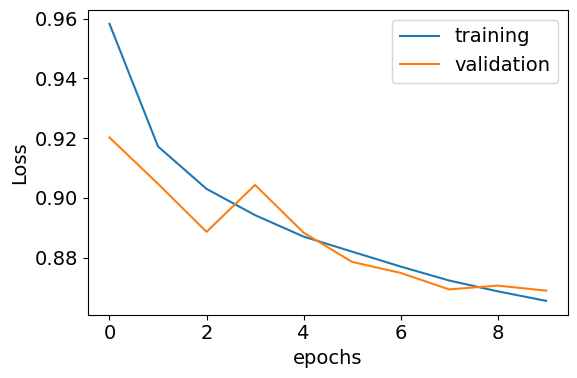

In [143]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))

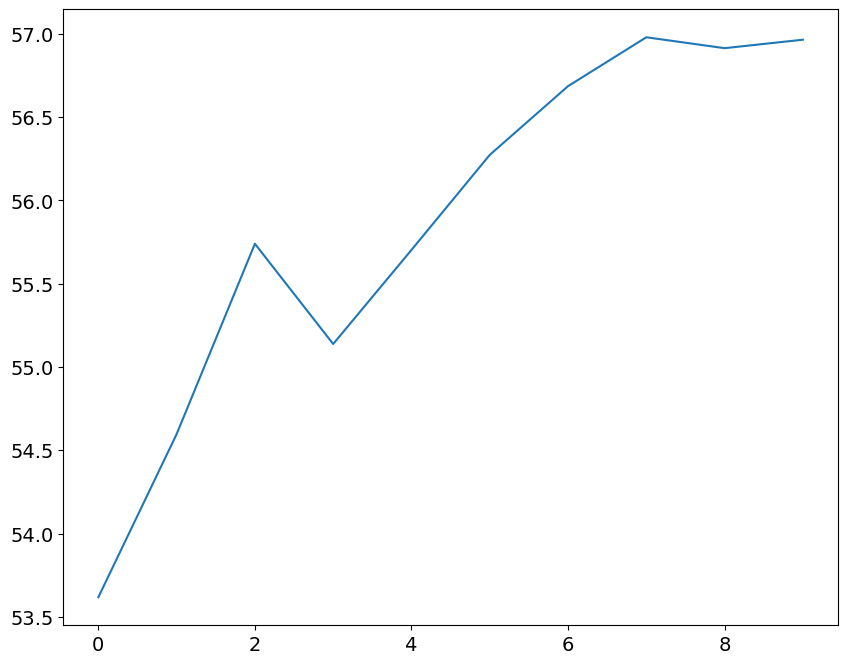

In [144]:
plt.plot(acc)

In [145]:
train_losses, val_losses, acc = train_cnn_pred(train_loader, val_loader, modelrn, 
                                               optimizerrn, device, criterion, 
                                               iprnt=1000, epochs=10)


Running for epochs ->10

EPOCH 0
Training step: size of sample 3590
Train Step 1000/3590, Loss: 0.8437529802322388
Train Step 2000/3590, Loss: 0.8621629476547241
Train Step 3000/3590, Loss: 0.851298451423645
Validation step: size of sample 1026
Validation Step 1000/1026, Loss: 0.8034136891365051
--- EPOCH 0 AVG TRAIN LOSS: 0.8609079703813144
--- EPOCH 0 AVG VAL LOSS: 0.8701345433733384
Accuracy on the 1026 validation images: 56.89977962829339 %

EPOCH 1
Training step: size of sample 3590
Train Step 1000/3590, Loss: 0.8451605439186096
Train Step 2000/3590, Loss: 0.8244150280952454
Train Step 3000/3590, Loss: 0.7956166863441467
Validation step: size of sample 1026
Validation Step 1000/1026, Loss: 0.8579260110855103
--- EPOCH 1 AVG TRAIN LOSS: 0.857852735260403
--- EPOCH 1 AVG VAL LOSS: 0.8751754427862446
Accuracy on the 1026 validation images: 56.65795580864715 %

EPOCH 2
Training step: size of sample 3590
Train Step 1000/3590, Loss: 0.867654025554657
Train Step 2000/3590, Loss: 0.884023

In [67]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    modelrn, optimizerrn, device, criterion, 
                                    batch_size=500, epochs=10, iprnt=2000)

Training with  ->3430000 images
size of train loader  ->6860 images
Evaluating with  ->980000 images
size of eval loader  ->1960 images
Running for epochs ->10

EPOCH 0
Train Step 2000/6860, Loss: 5.824728488922119
Train Step 4000/6860, Loss: 4.730734348297119
Train Step 6000/6860, Loss: 4.270293235778809
--- EPOCH 0 AVG TRAIN LOSS: 5.574861196248246
--- EPOCH 0 AVG VAL LOSS: 3.9234352578313985

EPOCH 1
Train Step 2000/6860, Loss: 5.496000289916992
Train Step 4000/6860, Loss: 3.626014471054077
Train Step 6000/6860, Loss: 3.563673257827759
--- EPOCH 1 AVG TRAIN LOSS: 4.464049956298083
--- EPOCH 1 AVG VAL LOSS: 3.6884452086930373

EPOCH 2
Train Step 2000/6860, Loss: 4.650121688842773
Train Step 4000/6860, Loss: 5.032261848449707
Train Step 6000/6860, Loss: 5.549496173858643
--- EPOCH 2 AVG TRAIN LOSS: 4.198680238960089
--- EPOCH 2 AVG VAL LOSS: 3.399690685953413

EPOCH 3
Train Step 2000/6860, Loss: 4.268925666809082
Train Step 4000/6860, Loss: 5.444616794586182
Train Step 6000/6860, Loss

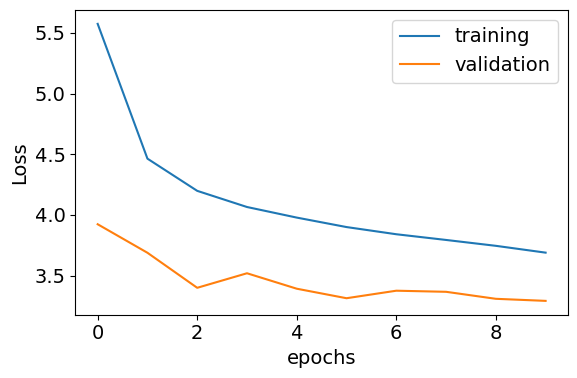

In [68]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))



In [69]:
tdeltas = evaluate_cnn(test_loader, modelrn, device, pixel_size = 3, energy=False)

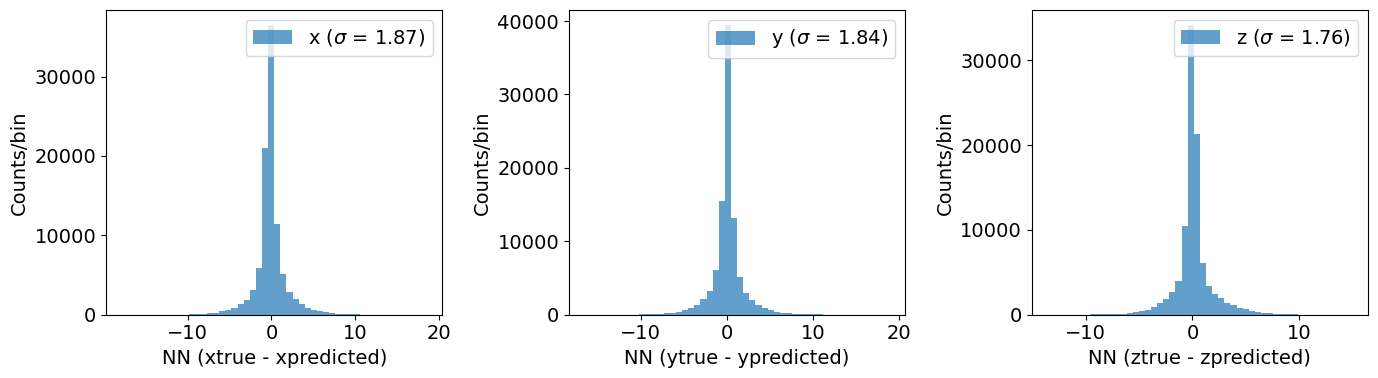

In [70]:
plotxyz(tdeltas, nbins=50)

In [71]:
f2gz, f2gx, f2gy = fit_coord(tdeltas, bins=100)

2g fit: mu1 = 0.12, sigma = 2.00, n1  =0.12
2g fit: mu2 = -0.03, sigma = 0.36, n1  =0.88
weighted error: = 0.57
2g fit: mu1 = -0.21, sigma = 0.38, n1  =0.81
2g fit: mu2 = -0.06, sigma = 1.69, n1  =0.19
weighted error: = 0.63
2g fit: mu1 = 0.07, sigma = 1.55, n1  =0.21
2g fit: mu2 = 0.09, sigma = 0.33, n1  =0.79
weighted error: = 0.59


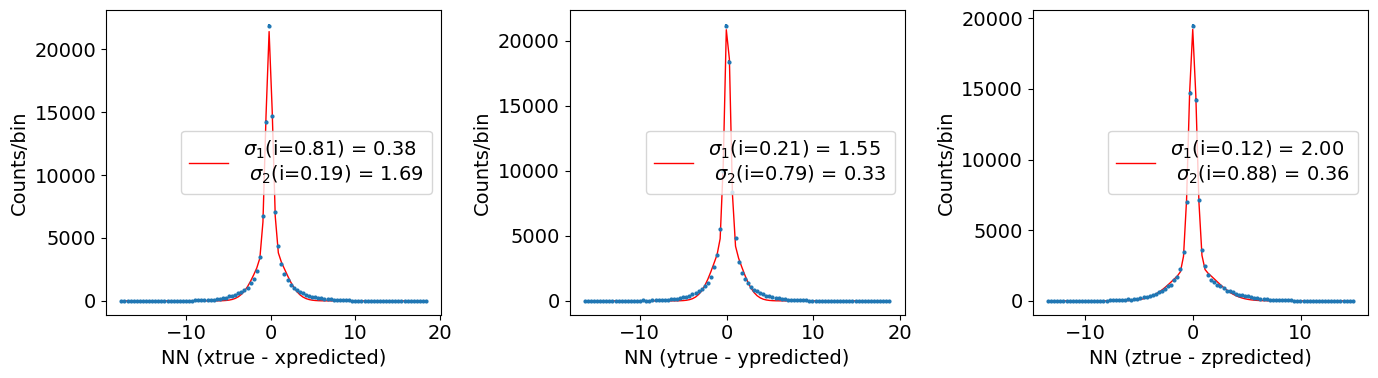

In [72]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))